In [10]:
import numpy as np
import pandas as pd
from HelperFunctions import prepare_data_nn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('final_df.csv', index_col='TIME')
df.head(1)

,ACTUAL_MW,DAM_MW,2DA_MW,temp
TIME,,,,
2021-03-26 11:00:00+00:00,279.0,289.85,289.2,57.02


In [3]:
actual_data = df[['ACTUAL_MW', 'temp']]
actual_data.head(1)

,ACTUAL_MW,temp
TIME,,
2021-03-26 11:00:00+00:00,279.0,57.02


In [8]:
#split and prepare data
x_train, y_train, x_val, y_val, x_test, y_test = prepare_data_nn(actual_data, pred_forward=24, look_back=24*7)



In [9]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape,  x_test.shape, y_test.shape

((19803, 168, 2), (19803,), (2475, 168, 2), (2475,), (2475, 168, 2), (2475,))

In [15]:
#scaler
scaler = MinMaxScaler()

#dims of .shape
num_samples, num_timesteps, num_features = x_train.shape

# reshape for sclaing
x_train_reshaped = x_train.reshape(-1, num_timesteps * num_features) #reshape to 2D for scaling
scaler.fit(x_train_reshaped)

#transform and reshape back to orginal shape
x_train_scaled = scaler.transform(x_train_reshaped).reshape(num_samples, num_timesteps, num_features)
x_val_scaled = scaler.transform(x_val.reshape(-1, num_timesteps * num_features)).reshape(x_val.shape)
x_test_scaled = scaler.transform(x_test.reshape(-1, num_timesteps * num_features)).reshape(x_test.shape)


In [16]:
x_train.shape, x_train_reshaped.shape

((19803, 168, 2), (19803, 336))

### LSTM

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer
from tensorflow.keras.optimizers import Adam


num_samples, num_timesteps, num_features = x_train.shape

#LSTM model1
model = Sequential()
model.add(InputLayer(input_shape=(num_timesteps, num_features)))
model.add(LSTM(64))  
model.add(Dense(20, activation='relu'))  
model.add(Dense(1))  # Output layer

#compile
model.compile(optimizer='adam', loss='mean_squared_error')

#fit
history = model.fit(x_train_scaled, y_train, epochs=20, batch_size=32, validation_data=(x_val_scaled, y_val))

#summary
model.summary()


Epoch 1/20
619/619 [==============================] - 25s 39ms/step - loss: 54620.0703 - val_loss: 19595.1074
Epoch 2/20
619/619 [==============================] - 24s 39ms/step - loss: 8275.2207 - val_loss: 12335.0654
Epoch 3/20
619/619 [==============================] - 24s 39ms/step - loss: 7847.8403 - val_loss: 13828.0537
Epoch 4/20
619/619 [==============================] - 24s 39ms/step - loss: 5692.6201 - val_loss: 3609.3777
Epoch 5/20
619/619 [==============================] - 24s 39ms/step - loss: 1592.6262 - val_loss: 1745.1919
Epoch 6/20
619/619 [==============================] - 24s 39ms/step - loss: 1211.1375 - val_loss: 1487.9069
Epoch 7/20
619/619 [==============================] - 24s 39ms/step - loss: 1115.7468 - val_loss: 1405.5378
Epoch 8/20
619/619 [==============================] - 26s 42ms/step - loss: 1071.6686 - val_loss: 1409.4592
Epoch 9/20
619/619 [==============================] - 25s 40ms/step - loss: 1039.3497 - val_loss: 1396.5149
Epoch 10/20
619/619 [===

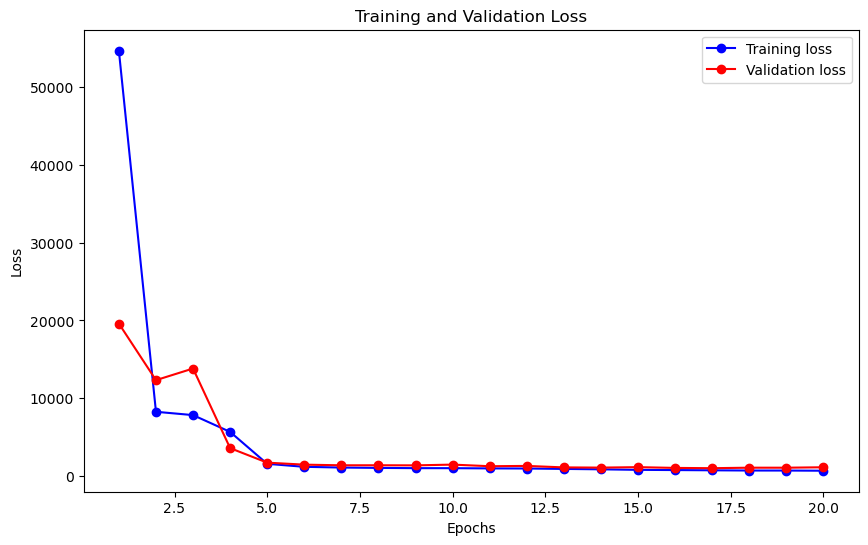

In [20]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(loss) + 1)


plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [25]:
predictions = model.predict(x_test_scaled)



y_test_flat = y_test.flatten()
predictions_flat = predictions_unscaled.flatten()

78/78 [==============================] - 1s 11ms/step


In [26]:
predictions

array([[413.02847],
       [391.4061 ],
       [365.94345],
       ...,
       [288.65265],
       [282.7102 ],
       [273.64142]], dtype=float32)

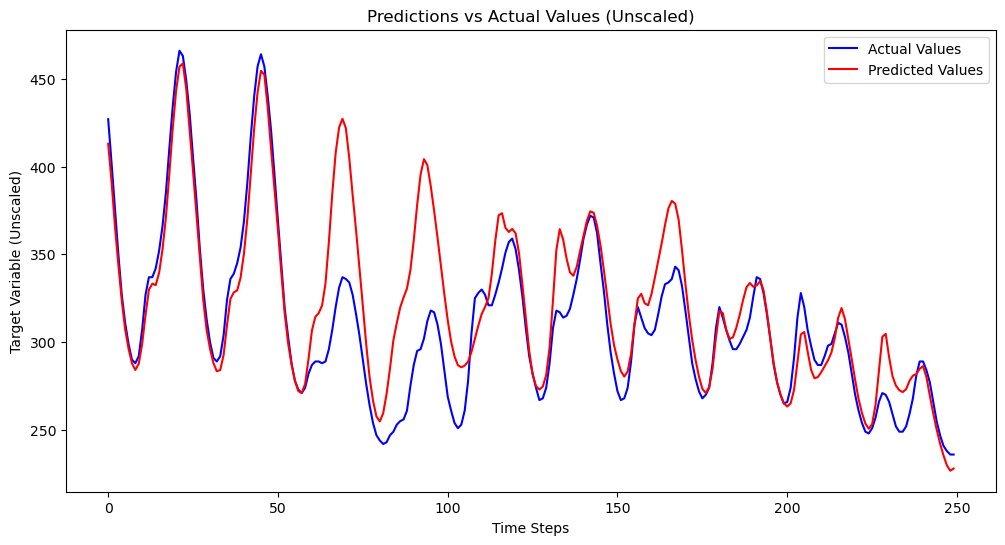

In [46]:


#Quick visual inspection
import matplotlib.pyplot as plt

start = 0
end = 250

plt.figure(figsize=(12, 6))
plt.plot(y_test[start:end], label='Actual Values', color='blue')
plt.plot(predictions[start:end], label='Predicted Values', color='red')
plt.title('Predictions vs Actual Values (Unscaled)')
plt.xlabel('Time Steps')
plt.ylabel('Target Variable (Unscaled)')
plt.legend()
plt.show()
